In [57]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from matplotlib.colors import LogNorm

In [58]:
DATA_DIR = "data"
READ_DIR = "instances"
BASELINE_STORE_DIR = "baseline"
FAIRNESS_STORE_DIR = "fairness"
TUNING_STORE_DIR = "tuning"
EXP_STORE_DIR = "experiments"
COMP_STORE_DIR = "competition"

In [59]:
# define plot labels for column names and row values
def format_labels(col_str: str):
    return " ".join(word.replace("par", "").capitalize() for word in col_str.split("_"))


def get_display_labels(data: pd.DataFrame):
    return dict(zip(data.columns, map(format_labels, data.columns)))


def format_data(row_str: str):
    row_words = row_str.split("_") if "_" in row_str else re.split(r"(\d+)", row_str)
    return " ".join(word.capitalize() for word in row_words) if len(row_words) > 1 else row_words[0].upper()

In [60]:
def read_data_executions(store_dir: str, instance_size: str, instance_type: str, algorithm_prefix: str):
    # parse in persisted data jsons
    exec_dicts, conv_dicts = [], []
    exec_routes = {}
    data_path = Path("..") / DATA_DIR / store_dir / instance_size / instance_type
    file_path = Path(f"{algorithm_prefix}*") / "*.json"
    print(f"Reading from {data_path}")
    executions = data_path.rglob(str(file_path))
    for algorithm_path in executions:
        with open(algorithm_path, "r") as f:
            exec_data = json.load(f)
            instance_size, instance_type, instance_id, algorithm, best_solution, args, iter_n, iter_score, best_score, best_runtime = exec_data.values()
            if algorithm not in exec_routes.keys():
                exec_routes[algorithm] = []
        exec_dicts.append({"instance": instance_id, "algorithm": algorithm, "best_score": best_score, "best_runtime": best_runtime})
        conv_dicts.append({"instance": instance_id, "algorithm": algorithm, "score": iter_score, "iteration": range(iter_n)})
        exec_routes[algorithm] += [[len(x) for x in best_solution]]
    # construct data frames
    exec_df = pd.DataFrame(exec_dicts)
    conv_df = pd.concat([pd.DataFrame(conv_dict) for conv_dict in conv_dicts], axis=0)
    exec_df["instance"] = exec_df["instance"].apply(format_data)
    exec_df["algorithm"] = exec_df["algorithm"].apply(format_data)
    conv_df["algorithm"] = conv_df["algorithm"].apply(format_data)
    return exec_df, conv_df, exec_routes

In [61]:
def read_data_tuning(instance_size: str, algorithm: str, iter_label: str):
    store_dir = TUNING_STORE_DIR
    instance_type = "train"
    data_path = Path("..") / DATA_DIR / store_dir / instance_size / instance_type / algorithm / "irace.csv"
    tune_df = pd.read_csv(data_path)
    tune_df["total_iterations"] = tune_df["n_iterations"] * tune_df[iter_label]
    return tune_df

In [62]:
def plot_performance_boxplot(exec_df: pd.DataFrame, y: str, title: str):
    x = "algorithm"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=exec_df,
        x=x,
        y=y,
        hue=x,
        legend=False,
        showfliers=False,
    )
    sns.stripplot(
        data=exec_df,
        x=x,
        y=y,
        hue=x,
        legend=False,
        jitter=True,
        alpha=0.5,
        palette="dark:black"
    )
    labels = get_display_labels(exec_df)
    plt.title(f"{title} - {labels[y]} of PDP Algorithms")
    plt.xlabel(labels[x])
    plt.ylabel(labels[y])
    plt.tight_layout()
    plt.show()

In [63]:
def plot_stops_heatmap(exec_routes: dict, title: str):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    for i, k in enumerate(exec_routes.keys()):
        sns.heatmap(
            exec_routes[k],
            cmap="viridis",
            ax=ax[i],
            vmin=0,
            vmax=300,
            cbar=(i == 2),
            cbar_kws={"label": "Number of Stops"},
        )
        ax[i].set_title(format_labels(k))
        ax[i].get_yaxis().set_visible(False)

    plt.suptitle(f"{title} - Distribution of PDP Vehicle Stops")
    fig.supxlabel("Vehicle Number")
    fig.supylabel("Instance")
    plt.tight_layout()
    plt.show()

In [64]:
def plot_performance_heatmap(exec_df: pd.DataFrame, values: str, title: str):
    index, columns = "algorithm", "instance"
    heatmap_df = exec_df.pivot(index=index, columns=columns, values=values)
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_df,
        cmap="YlGnBu",
        norm=LogNorm(),
    )
    labels = get_display_labels(exec_df)
    plt.title(f"{title} - Log-scaled {labels[values]} of PDP Algorithms")
    plt.xlabel(labels[columns])
    plt.ylabel(labels[index])
    plt.tight_layout()
    plt.show()

In [65]:
def plot_convergence_history(conv_df: pd.DataFrame, title: str, instance: str = None):
    if instance:
        conv_df = conv_df[conv_df["instance"] == instance]
    x, y, hue = "iteration", "score", "algorithm"
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        data=conv_df,
    )
    labels = get_display_labels(conv_df)
    plt.xlim(0, conv_df[x].max() * 1.01)
    plt.ylim(0, conv_df[y].max() * 1.01)
    plt.title(f"{title} - Convergence of PDP Algorithms", fontsize=14)
    plt.xlabel(labels[x])
    plt.ylabel(labels[y])
    plt.legend(title=labels[hue], loc="lower right")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [66]:
def plot_tuning_relations(data: pd.DataFrame, xy_pairs: list[tuple], title: str):
    def draw_lineplot(data: pd.DataFrame, x, y, ax):
        labels = get_display_labels(data)
        sns.lineplot(data, x=x, y=y, ax=ax)
        ax.set_xlabel(labels[x])
        ax.set_ylabel(labels[y])

    fig, axs = plt.subplots(1, len(xy_pairs), figsize=(20, 6))
    for i, (x, y) in enumerate(xy_pairs):
        draw_lineplot(data, x, y, axs[i] if len(xy_pairs) > 1 else axs)
    plt.suptitle(f"{title} - Parameter Effects on PDP Algorithm", fontsize=14)
    plt.tight_layout()
    plt.show()

In [67]:
def plot_significance_hist(data: np.ndarray, group: str, title: str):
    plt.figure(figsize=(12, 6))
    plt.hist(data, density=True, alpha=0.5)
    mu, std = ss.norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 201)
    y = ss.norm.pdf(x, mu, std)
    plt.plot(x, y, "black")
    plt.title(f"{title} - Normal Fit of PDP Performance Difference with mu = {mu:.2f} and std = {std:.2f}", fontsize=14)
    plt.show()

In [68]:
def get_significance_test(data_A: np.ndarray, data_B: np.ndarray):
    wilcoxon_test = ss.wilcoxon(data_A, data_B, alternative="two-sided")
    print(f"H0: Both algorithms show same performance yielded p-value of {wilcoxon_test.pvalue}!")

## Task 2 - Fairness Comparison

Reading from ../data/fairness/1000/train


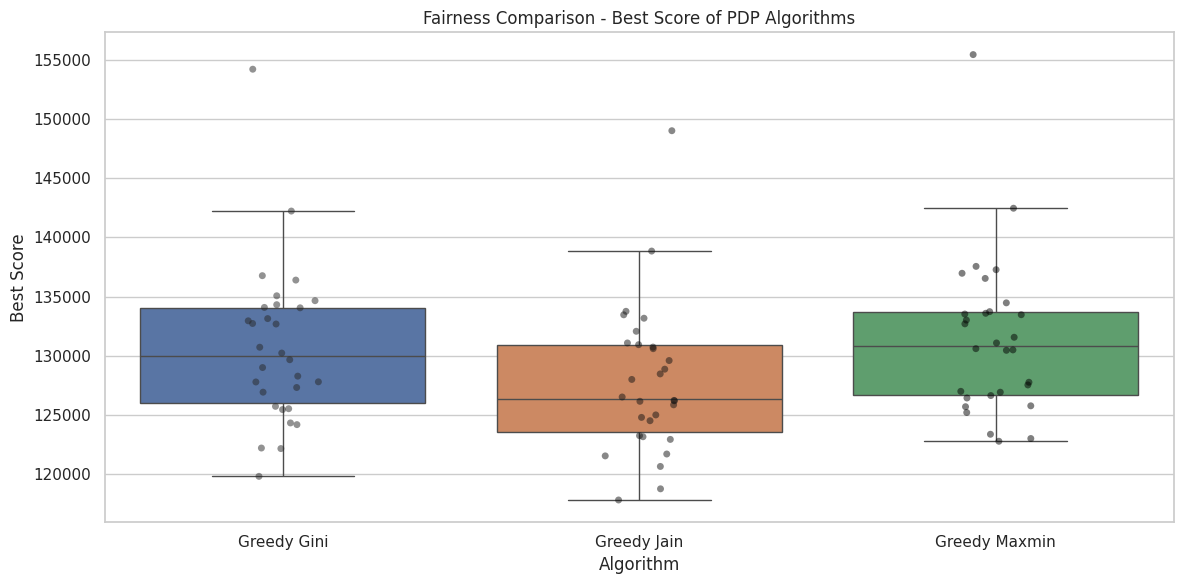

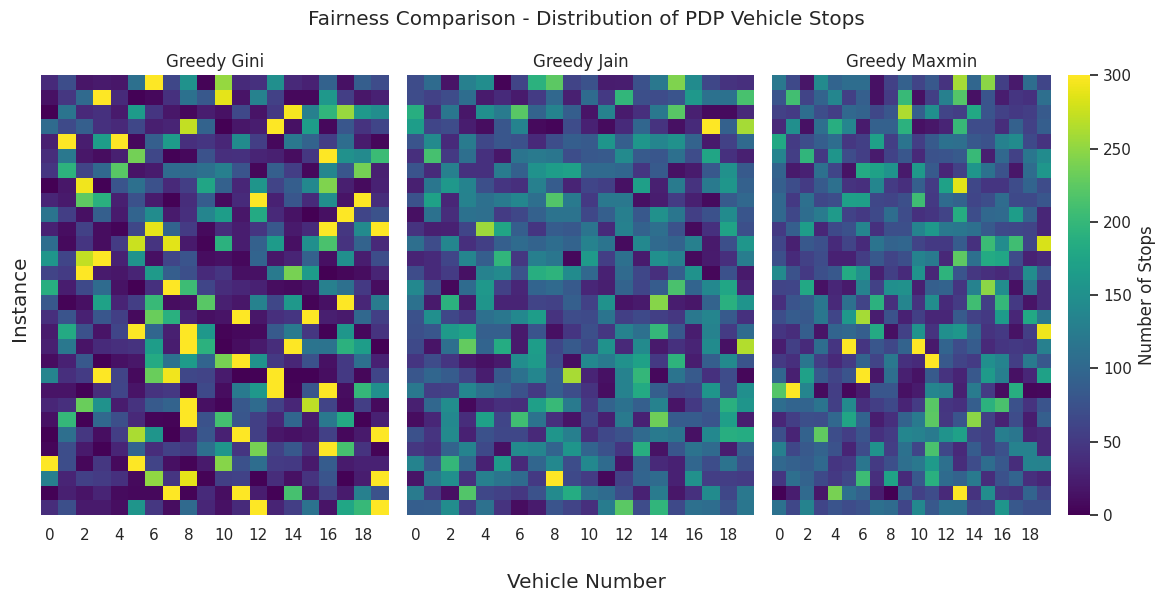

In [69]:
FAIRNESS_TITLE = "Fairness Comparison"
exec_df, conv_df, exec_routes = read_data_executions(FAIRNESS_STORE_DIR, "1000", "train", "greedy")
plot_performance_boxplot(exec_df, "best_score", FAIRNESS_TITLE)
plot_stops_heatmap(exec_routes, FAIRNESS_TITLE)

Reading from ../data/fairness/100/train


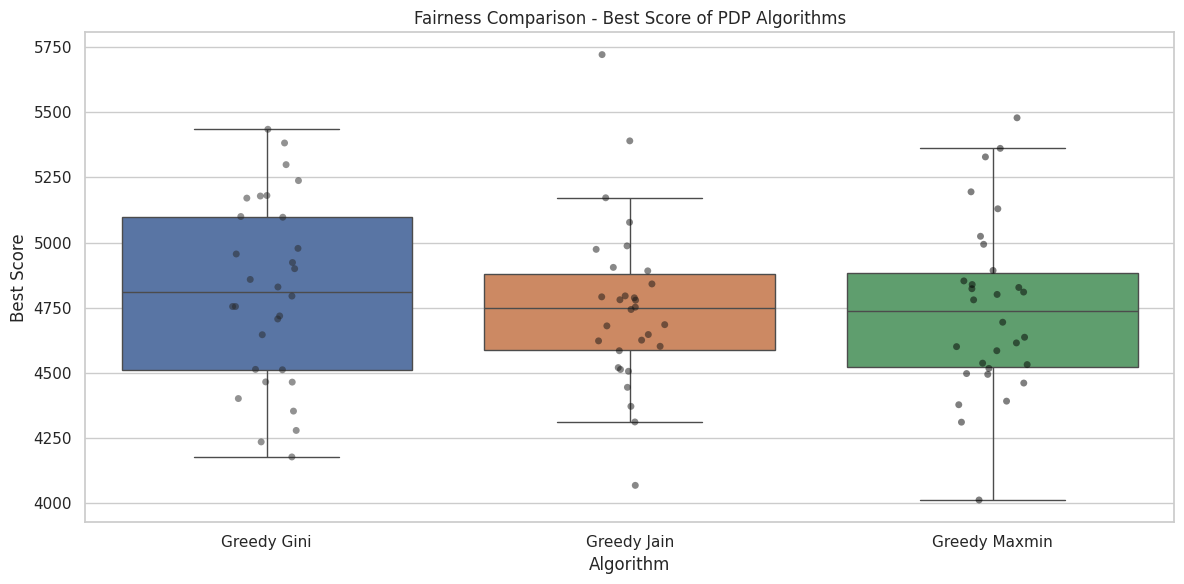

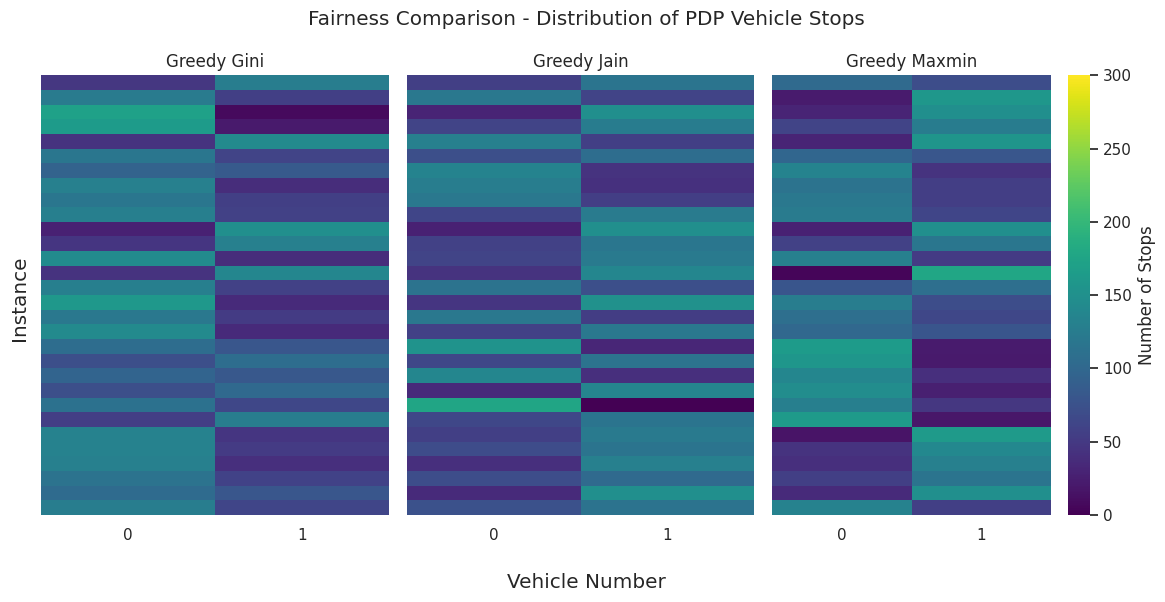

In [70]:
FAIRNESS_TITLE = "Fairness Comparison"
exec_df, conv_df, exec_routes = read_data_executions(FAIRNESS_STORE_DIR, "100", "train", "greedy")
plot_performance_boxplot(exec_df, "best_score", FAIRNESS_TITLE)
plot_stops_heatmap(exec_routes, FAIRNESS_TITLE)

Reading from ../data/fairness/100/train


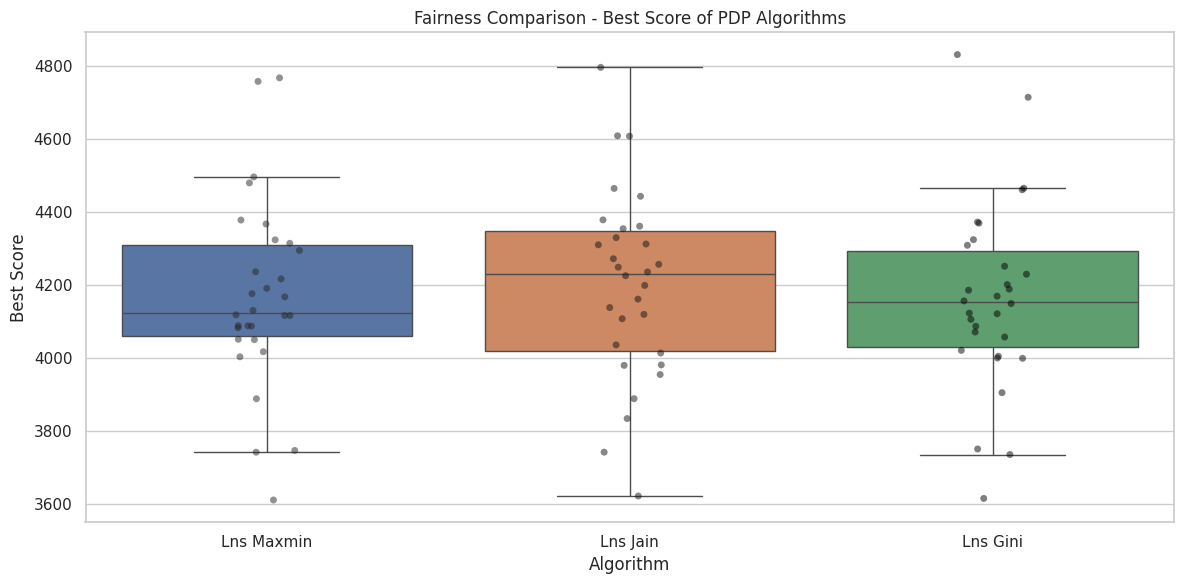

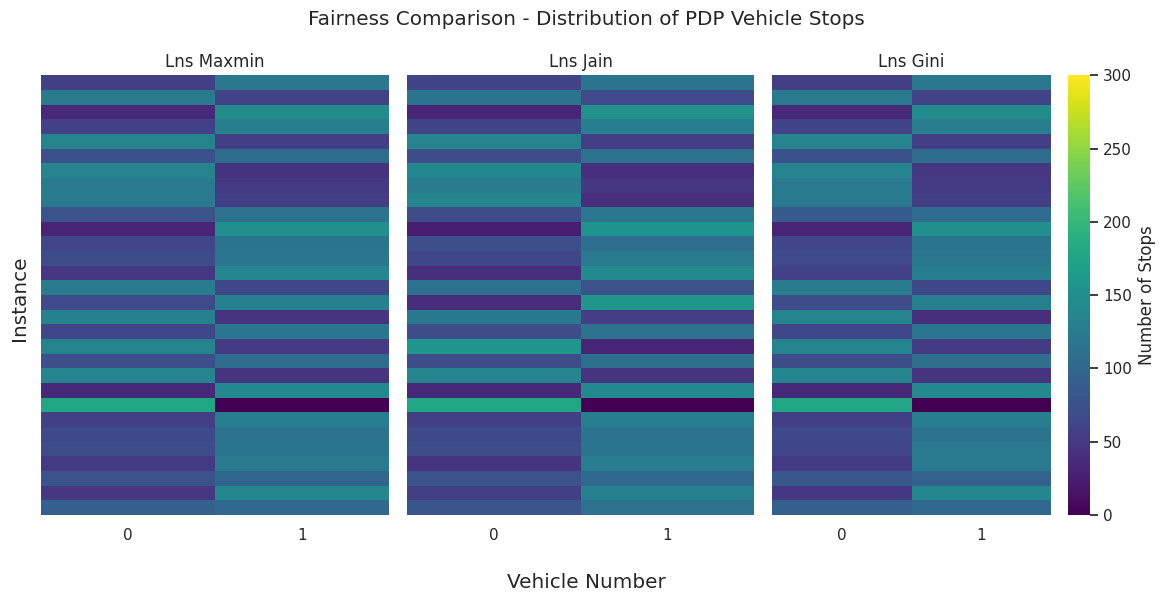

In [71]:
FAIRNESS_TITLE = "Fairness Comparison"
exec_df, conv_df, exec_routes = read_data_executions(FAIRNESS_STORE_DIR, "100", "train", "lns")
plot_performance_boxplot(exec_df, "best_score", FAIRNESS_TITLE)
plot_stops_heatmap(exec_routes, FAIRNESS_TITLE)

## Task 3 - iRace Parameter Tuning

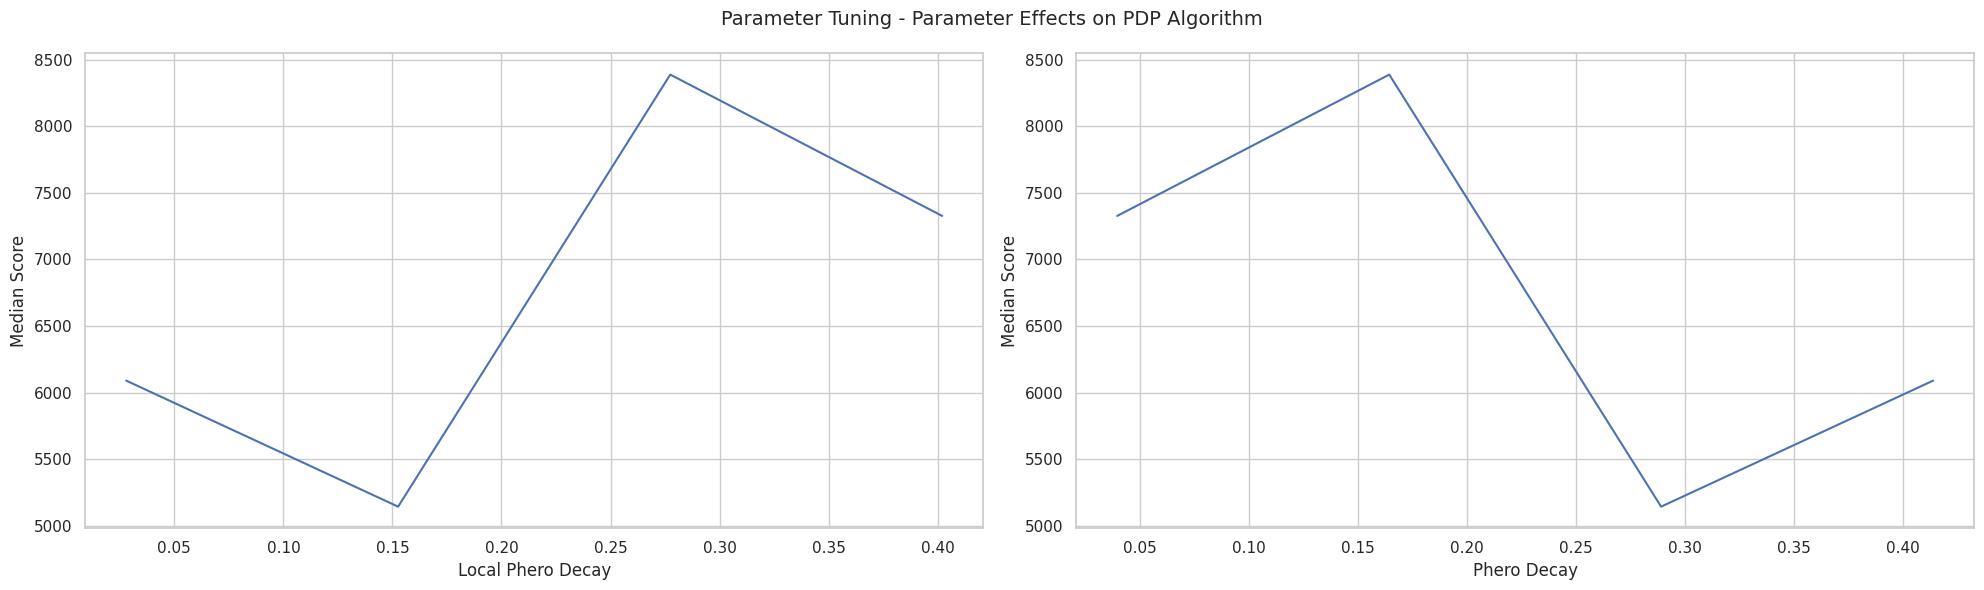

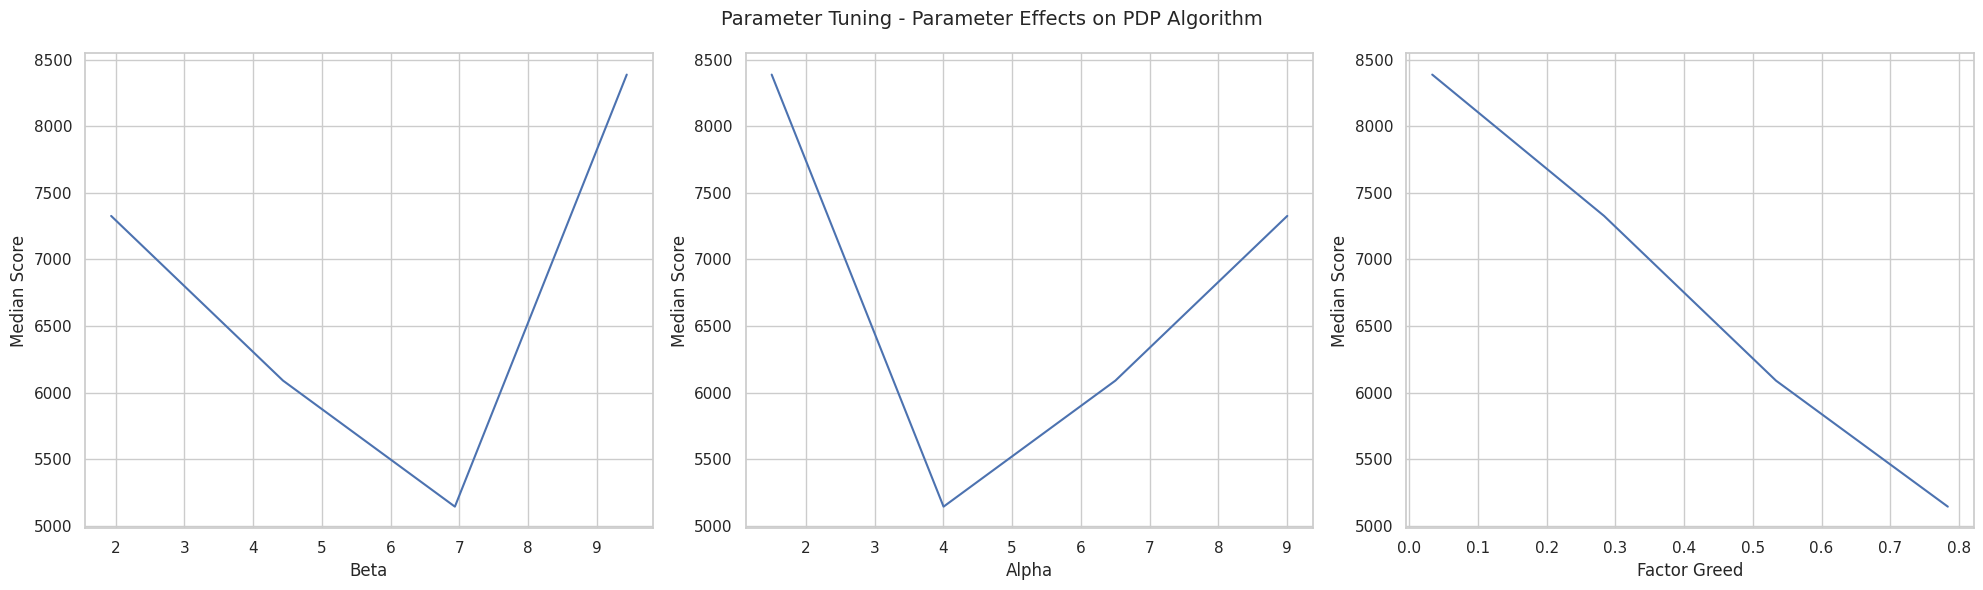

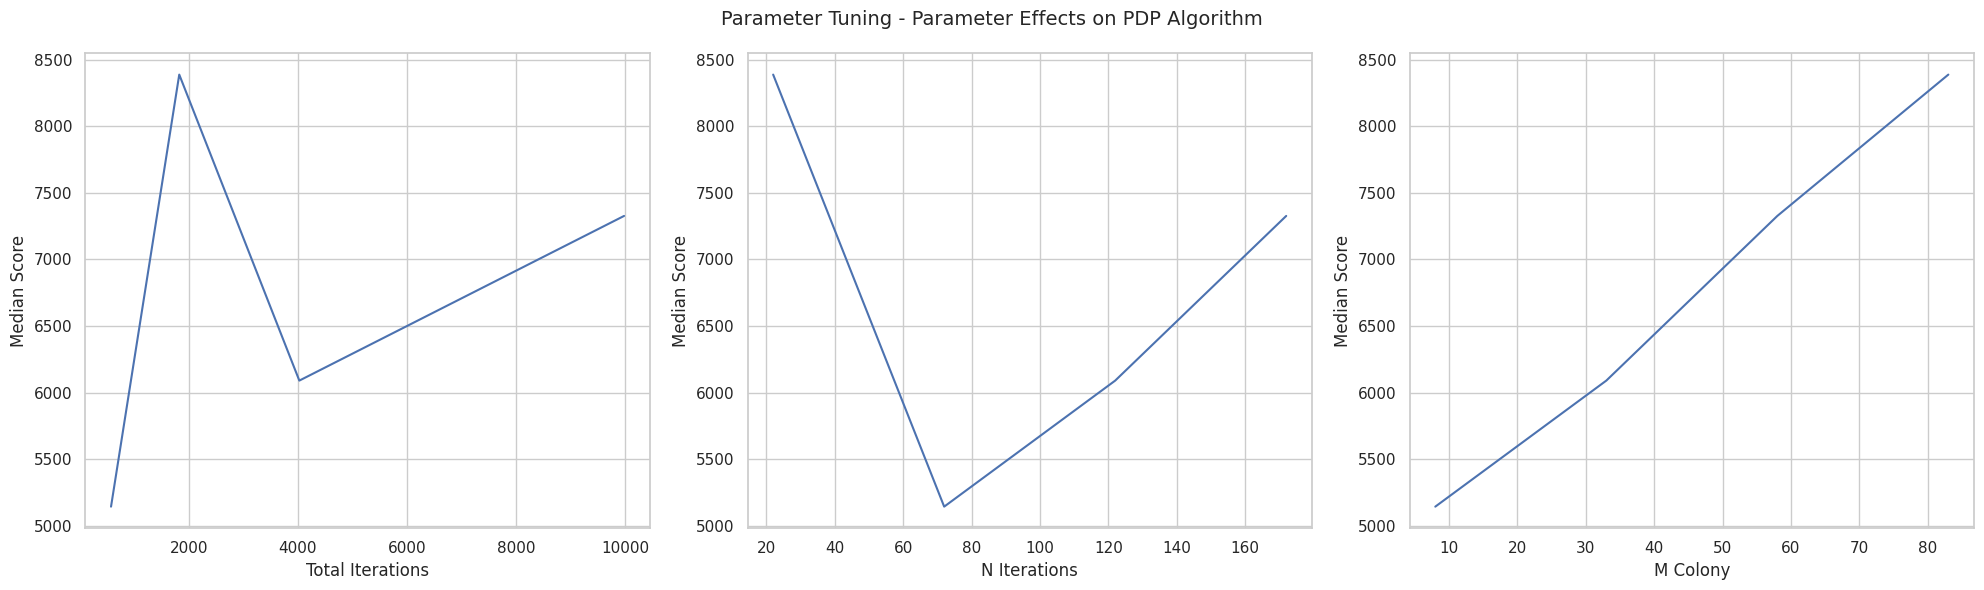

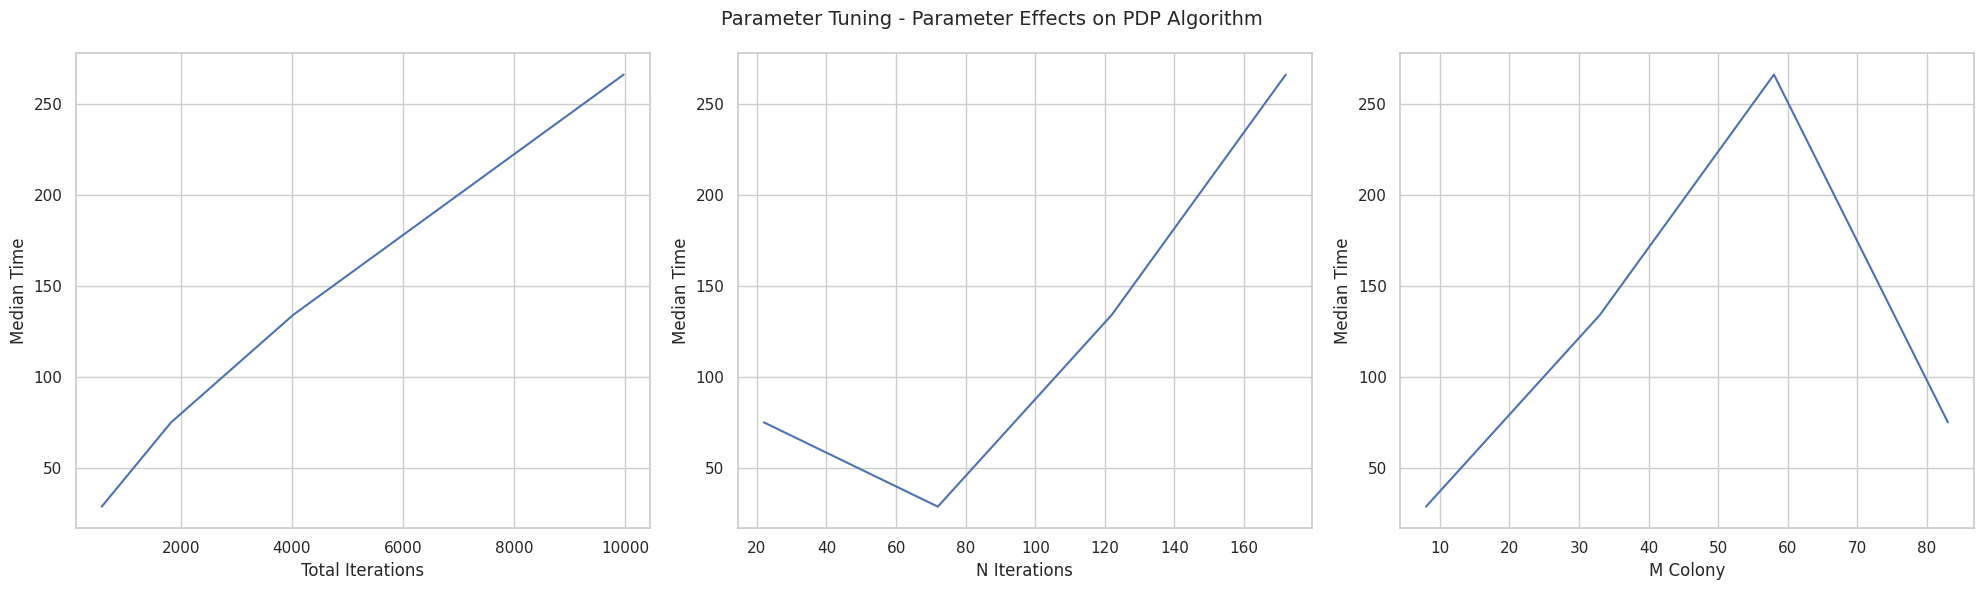

In [72]:
TUNING_TITLE = "Parameter Tuning"
tune_df = read_data_tuning("100", "acs", "m_colony")
tune_score_phero = [
    ("local_phero_decay", "median_score"),
    ("phero_decay", "median_score"),
]
tune_score_trans = [
    ("beta", "median_score"),
    ("alpha", "median_score"),
    ("factor_greed", "median_score"),
]
tune_score_runs = [
    ("total_iterations", "median_score"),
    ("n_iterations", "median_score"),
    ("m_colony", "median_score"),
]
tune_time_runs = [
    ("total_iterations", "median_time"),
    ("n_iterations", "median_time"),
    ("m_colony", "median_time"),
]
plot_tuning_relations(tune_df, tune_score_phero, TUNING_TITLE)
plot_tuning_relations(tune_df, tune_score_trans, TUNING_TITLE)
plot_tuning_relations(tune_df, tune_score_runs, TUNING_TITLE)
plot_tuning_relations(tune_df, tune_time_runs, TUNING_TITLE)

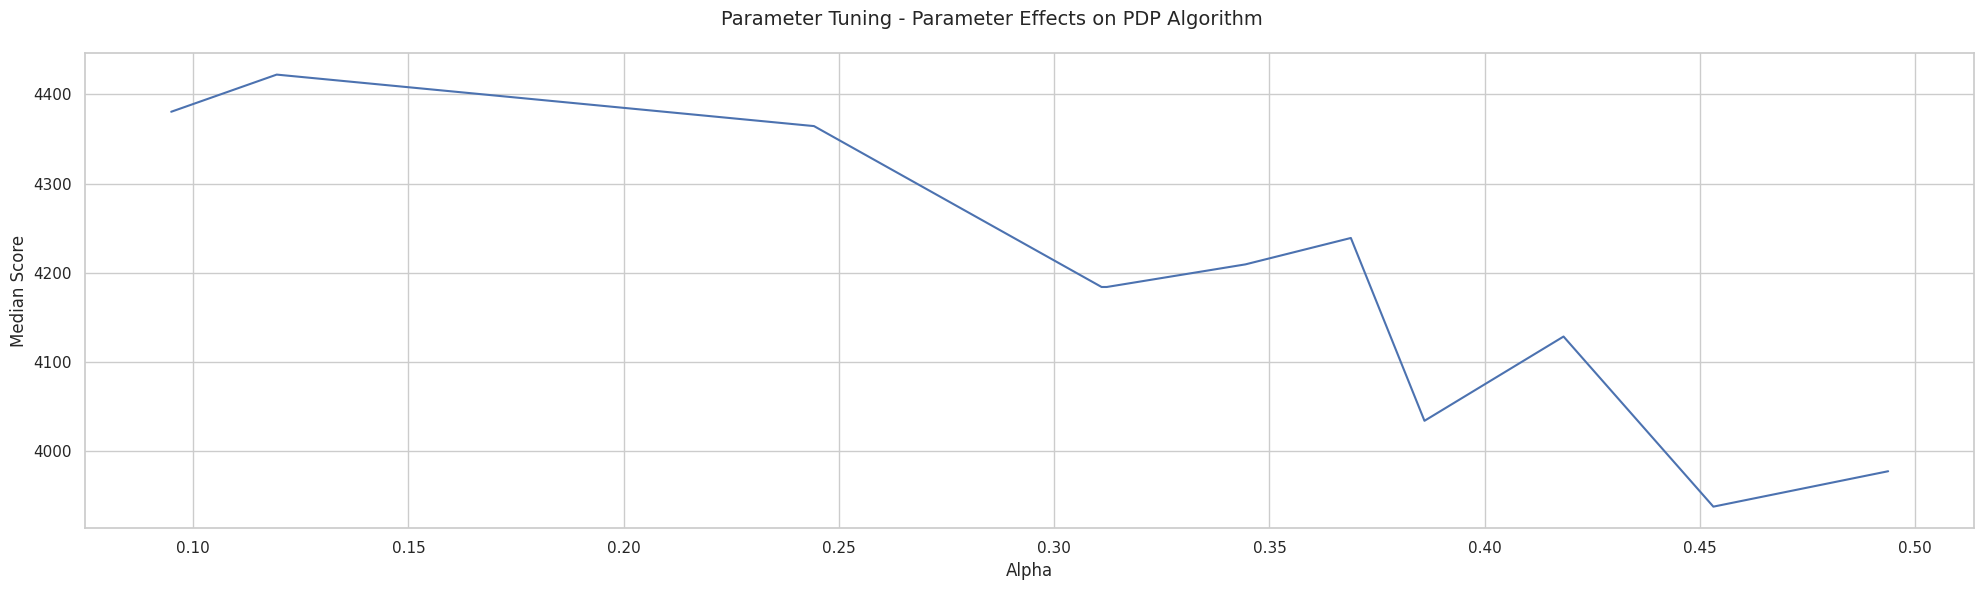

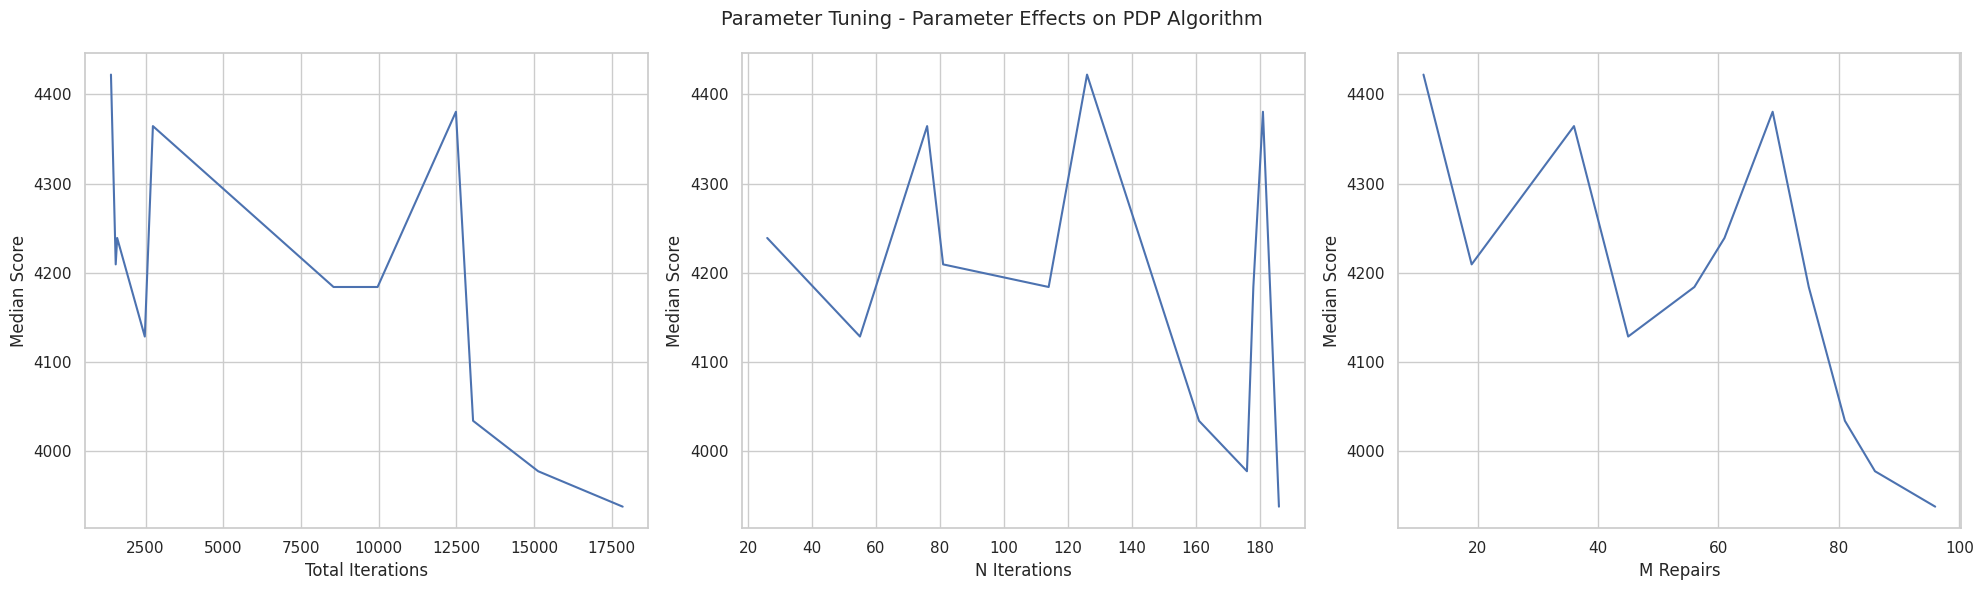

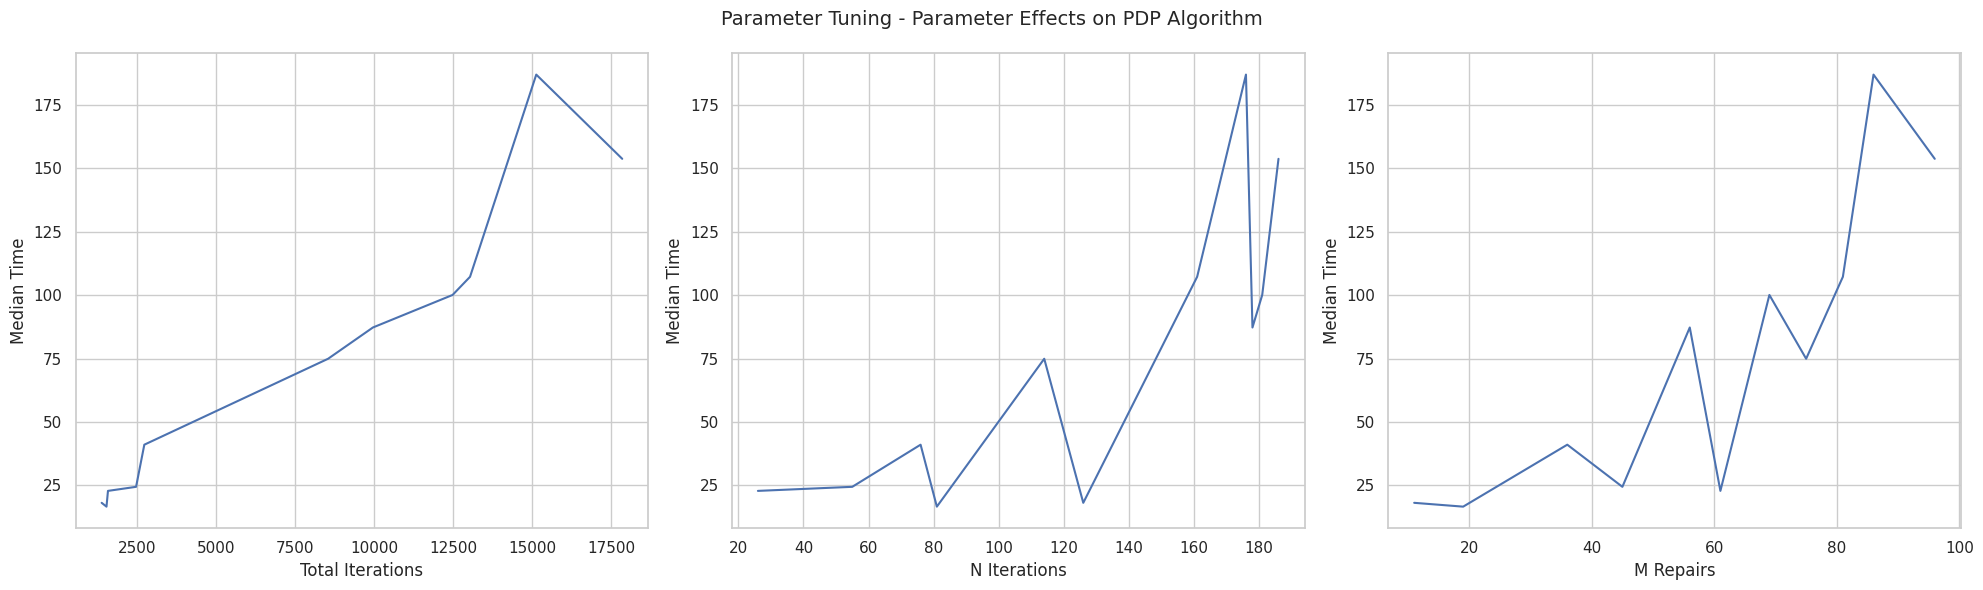

In [73]:
tune_df = read_data_tuning("100", "lns", "m_repairs")
tune_score = [
    ("alpha", "median_score"),
]
tune_score_runs = [
    ("total_iterations", "median_score"),
    ("n_iterations", "median_score"),
    ("m_repairs", "median_score"),
]
tune_time_runs = [
    ("total_iterations", "median_time"),
    ("n_iterations", "median_time"),
    ("m_repairs", "median_time"),
]
plot_tuning_relations(tune_df, tune_score, TUNING_TITLE)
plot_tuning_relations(tune_df, tune_score_runs, TUNING_TITLE)
plot_tuning_relations(tune_df, tune_time_runs, TUNING_TITLE)

## Task 4 - Best Experiments

Reading from ../data/experiments/100/test


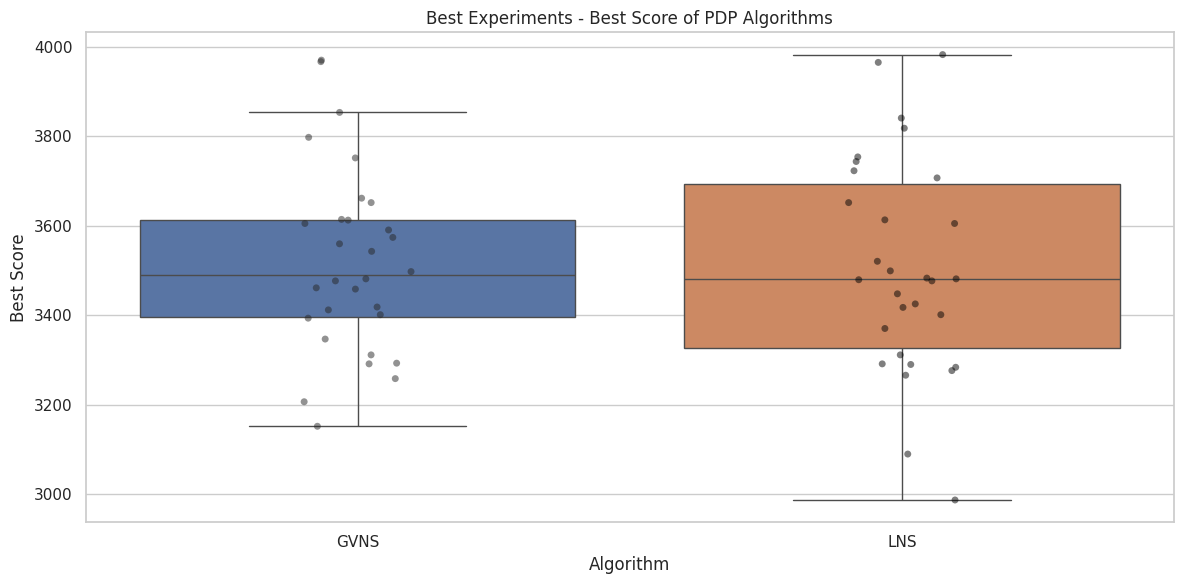

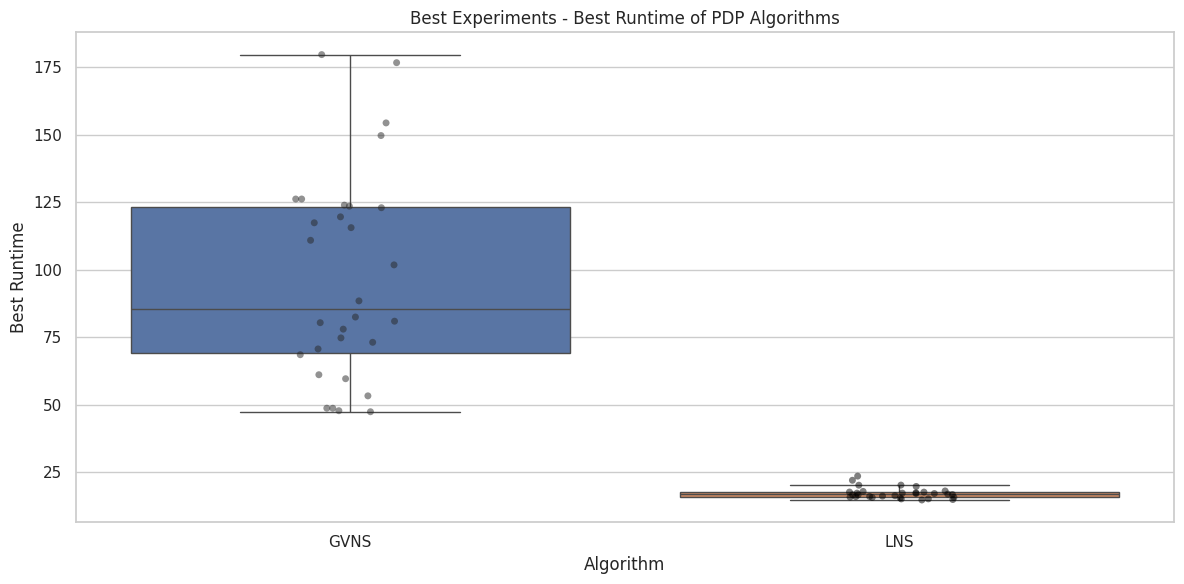

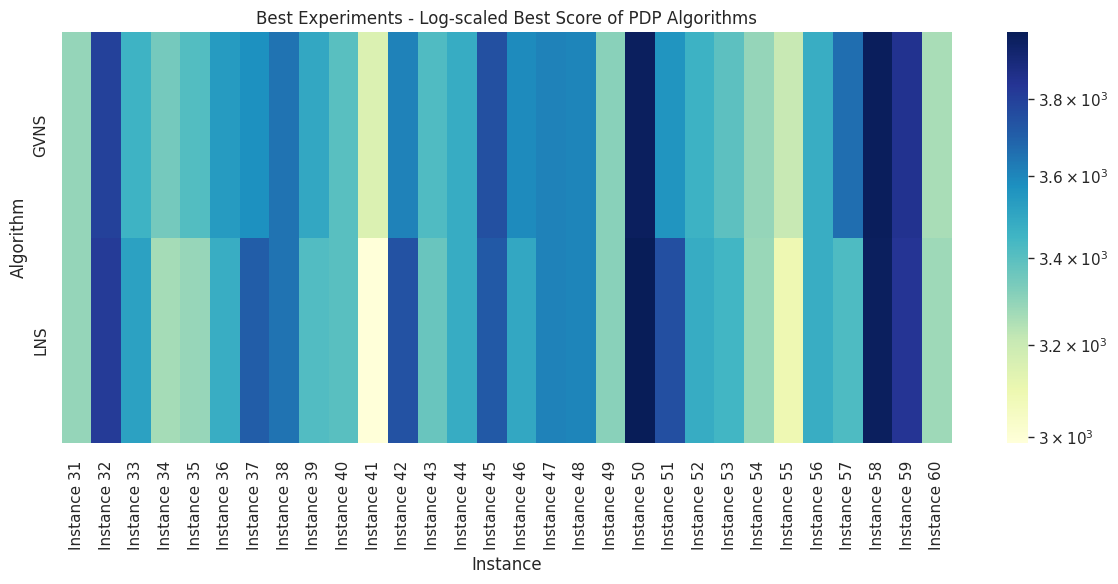

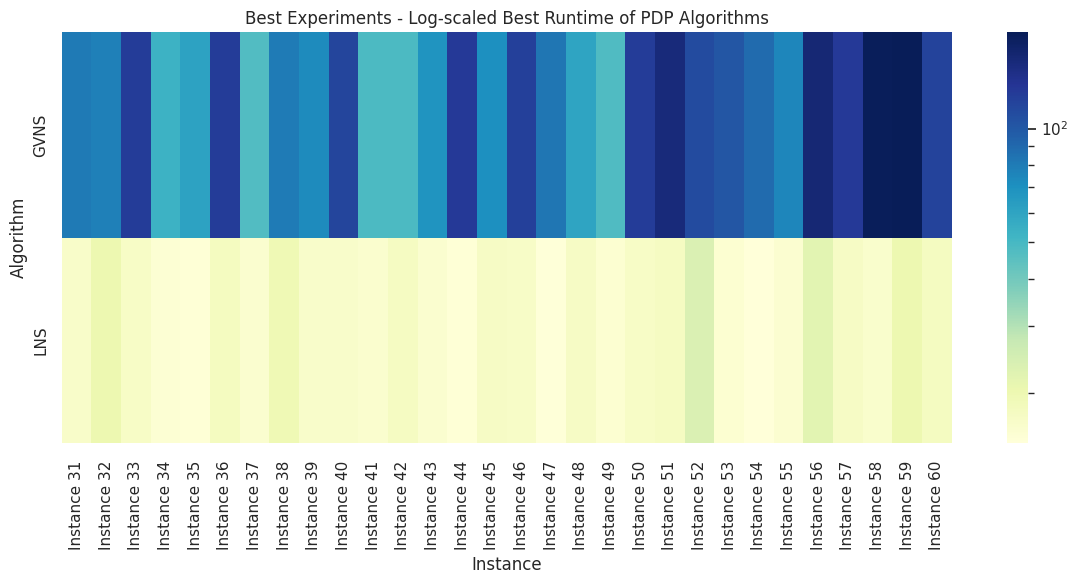

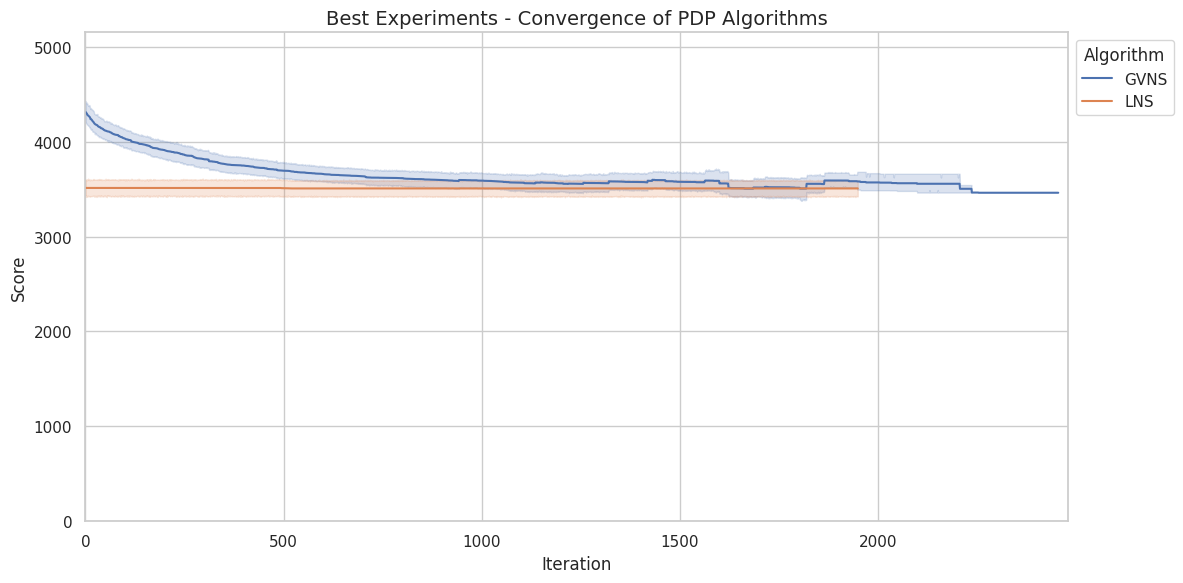

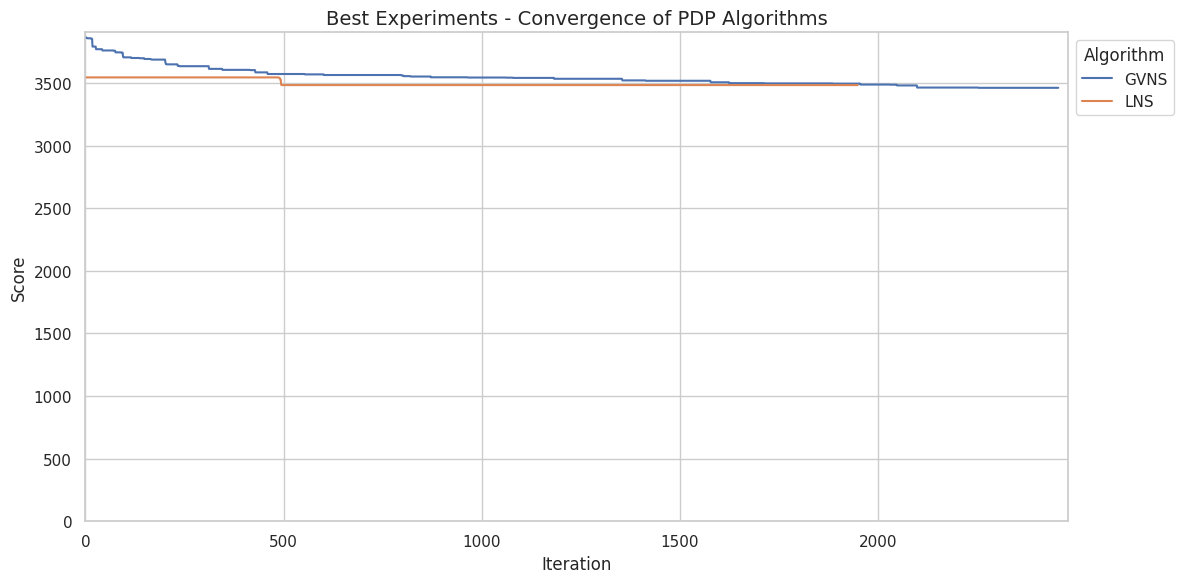

In [74]:
EXP_TITLE = "Best Experiments"
exec_df, conv_df, _ = read_data_executions(EXP_STORE_DIR, "100", "test", "")
plot_performance_boxplot(exec_df, "best_score", EXP_TITLE)
plot_performance_boxplot(exec_df, "best_runtime", EXP_TITLE)
plot_performance_heatmap(exec_df, "best_score", EXP_TITLE)
plot_performance_heatmap(exec_df, "best_runtime", EXP_TITLE)
plot_convergence_history(conv_df, EXP_TITLE)
plot_convergence_history(conv_df, EXP_TITLE, "instance52")

## Task 5 - Significance Tests

H0: Both algorithms show same performance yielded p-value of 0.4115302280988584!


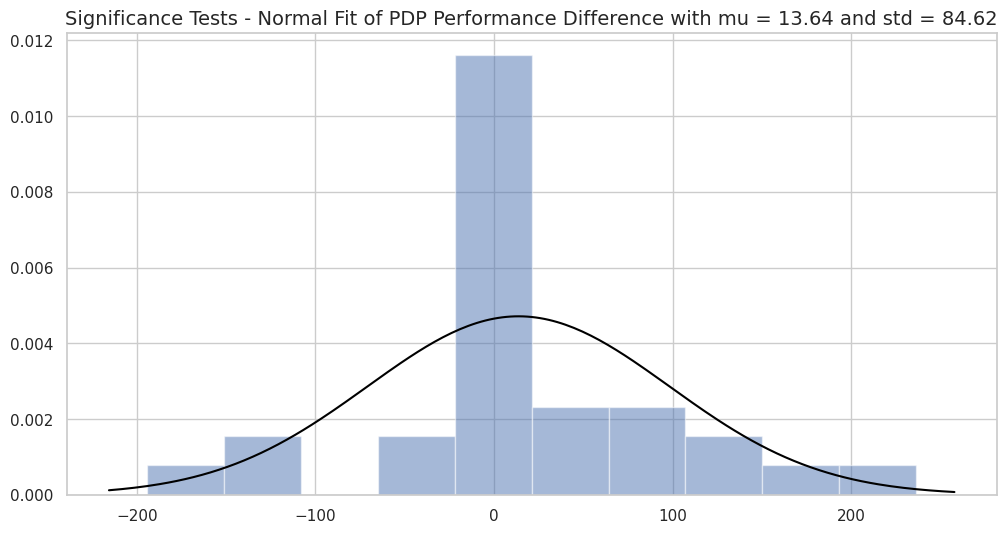

In [75]:
TESTING_TITLE = "Significance Tests"

algo_A = "GVNS"
algo_B = "LNS"
exec_df = exec_df.sort_values("instance")
exec_A = exec_df[exec_df["algorithm"] == algo_A]["best_score"].values
exec_B = exec_df[exec_df["algorithm"] == algo_B]["best_score"].values

get_significance_test(exec_A, exec_B)
plot_significance_hist(exec_A - exec_B, "difference", TESTING_TITLE)